# CIFAR-10 redux

In [22]:
# Back with a handrolled library to smoke CIFAR-10

# Autoimport for debugging purposes
%load_ext autoreload
%autoreload 2
%aimport pax
%aimport pax_optimizers
import os

# 1. don't preallocate all GPU memory upfront
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# 2. limit how much GPU memory JAX/XLA can grab (e.g. 80%)
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"

# 3. skip cudnn autotuning (avoids the huge temp workspace allocations)
# os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"

# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

# Imports
import jax
import jax.numpy as jnp
from functools import partial
from pax import Dense, Conv2D, BatchNorm, B33, GlobalAvgPool, Flatten
from pax_optimizers import Adam

# From https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def process_single_batch(batch):
    X, y = jnp.array(batch[b'data']), jnp.array(batch[b'labels'])
    X = jnp.reshape(X, (-1, 3, 32, 32))
    # X = jnp.transpose(X, [0, 2, 3, 1])
    return X, y

def load_and_combine_full_training_set():
    Xs, ys = [], []
    for i in range(1, 6):
        X, y = process_single_batch(unpickle(f'data/cifar-10-batches-py/data_batch_{i}'))
        Xs.append(X)
        ys.append(y)
    X = jnp.concatenate(Xs)
    y = jnp.concatenate(ys)
    return X, y

def augment_data(X_train):
    # horizontal_flip
    X_train = jnp.concatenate([X_train, X_train[:, :, :, ::-1]])
    return X_train

X_train, y_train = load_and_combine_full_training_set()
# X_train = augment_data(X_train)
X_train.shape, y_train.shape

((50000, 3, 32, 32), (50000,))

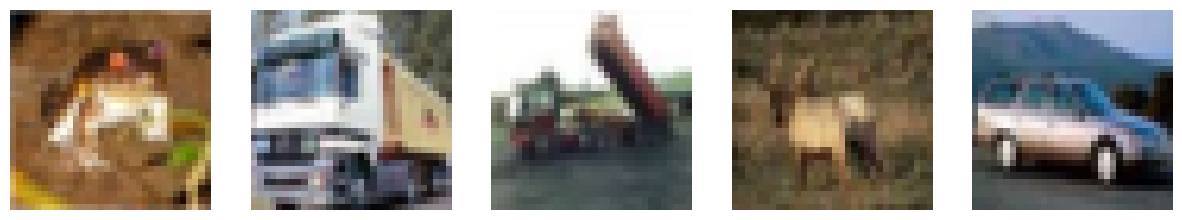

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# assuming X_train is jax.numpy array of shape (N, 32, 32, 3)
# convert first 5 images to numpy for plotting
images = np.array(X_train[:5])

# plot
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i].transpose((1,2,0)))
    ax.axis('off')
plt.show()

In [25]:
def get_epoch_batches(X, y, key, batch_size):
    num = (X.shape[0] // batch_size) * batch_size
    perm = jax.random.permutation(key, X.shape[0])[:num]
    X, y = X[perm], y[perm]
    X = X.reshape(-1, batch_size, *X.shape[1:])
    y = y.reshape(-1, batch_size, *y.shape[1:])
    return X, y

def expand_batch(X):
    return X.astype(jnp.float32) / 255.0
    # return X

bX, by = get_epoch_batches(X_train, y_train, jax.random.key(0), 16)
bX.shape, by.shape

((3125, 16, 3, 32, 32), (3125, 16))

In [26]:
def wideblock(*, init_stride, out_size, in_channels, out_channels, num_blocks=2):
    b33_1 = B33(init_stride=init_stride, in_size=out_size*init_stride,
                out_size=out_size, in_channels=in_channels,
                out_channels=out_channels)
    # only (num_blocks - 1) more blocks at same resolution
    return [b33_1] + [B33(1, out_size, out_size, out_channels, out_channels)] * (num_blocks - 1)

initial = [
    Conv2D(3, 3, 16, 1, 'SAME'),  # initial conv
]

final = [
    BatchNorm((256, 1, 1), (0,), momentum=0.01, activation=jax.nn.relu),
    GlobalAvgPool(),
    Flatten(),
    Dense(256, 10)  # final dense matches last stage channels
]

layers = (initial
          + wideblock(init_stride=1, out_size=32,  in_channels=16,  out_channels=64,  num_blocks=2)
          + wideblock(init_stride=2, out_size=16,  in_channels=64,  out_channels=128, num_blocks=2)
          + wideblock(init_stride=2, out_size=8,   in_channels=128, out_channels=256, num_blocks=2)
          + final)

In [27]:
params = tuple(l.weights(jax.random.key(0)) for l in layers)
state = tuple(l.state() for l in layers)

@partial(jax.jit, static_argnames="is_training")
def fwd(params, state, X, *, is_training, key):
    X = expand_batch(X)
    for i, layer in enumerate(layers):
        key, subkey = jax.random.split(key)
        # print(X.shape)
        # print(jax.tree.structure(params[i]))
        # print(jax.tree.map_with_path(lambda p, X: f'{p}: {X.shape}', params[i]))
        X, state_i = layer.func()(params[i], state[i], X, is_training=is_training, key=subkey)
        state = state[:i] + (state_i,) + state[i+1:]  # update tuple immutably
    return X, state

@jax.jit
def loss_fn(params, state, X, y, *, key):
    logits, new_state = fwd(params, state, X, is_training=True, key=key)
    loss = -jnp.mean(jax.nn.log_softmax(logits)[jnp.arange(y.size), y])
    return loss, new_state

# Xb, yb = bX[0], by
(loss_val, new_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, bX[0], by[0], key=jax.random.key(0))
# fwd(params, state, bX[0], is_training=False, key=jax.random.key(1))

jax.tree.structure([loss_val, new_state, grads])

PyTreeDef([*, ({}, {'bn1': {'rmean': *, 'rvar': *}, 'bn2': {'rmean': *, 'rvar': *}}, {'bn1': {'rmean': *, 'rvar': *}, 'bn2': {'rmean': *, 'rvar': *}}, {'bn1': {'rmean': *, 'rvar': *}, 'bn2': {'rmean': *, 'rvar': *}}, {'bn1': {'rmean': *, 'rvar': *}, 'bn2': {'rmean': *, 'rvar': *}}, {'bn1': {'rmean': *, 'rvar': *}, 'bn2': {'rmean': *, 'rvar': *}}, {'bn1': {'rmean': *, 'rvar': *}, 'bn2': {'rmean': *, 'rvar': *}}, {'rmean': *, 'rvar': *}, {}, {}, {}), ({'b': *, 'w': *}, {'bn1': {'beta': *, 'gamma': *}, 'bn2': {'beta': *, 'gamma': *}, 'conv1': {'b': *, 'w': *}, 'conv2': {'b': *, 'w': *}, 'cskip': {'b': *, 'w': *}}, {'bn1': {'beta': *, 'gamma': *}, 'bn2': {'beta': *, 'gamma': *}, 'conv1': {'b': *, 'w': *}, 'conv2': {'b': *, 'w': *}, 'cskip': {'b': *, 'w': *}}, {'bn1': {'beta': *, 'gamma': *}, 'bn2': {'beta': *, 'gamma': *}, 'conv1': {'b': *, 'w': *}, 'conv2': {'b': *, 'w': *}, 'cskip': {'b': *, 'w': *}}, {'bn1': {'beta': *, 'gamma': *}, 'bn2': {'beta': *, 'gamma': *}, 'conv1': {'b': *, 'w':

In [45]:
from functools import partial

def lr_schedule(epoch, max_epochs, base_lr=3e-3, min_lr=1e-6, warmup=3):
    def warmup_fn(epoch):
        return base_lr * (epoch + 1) / warmup

    def decay_fn(epoch):
        decay_epoch = epoch - warmup
        decay_total = max_epochs - warmup
        cosine = 0.5 * (1 + jnp.cos(jnp.pi * decay_epoch / decay_total))
        return min_lr + (base_lr - min_lr) * cosine

    return jax.lax.cond(epoch < warmup, warmup_fn, decay_fn, epoch)


@partial(jax.jit, static_argnames=['batch_size', 'num_epochs'])
def train(X, y, key, init_params, init_state, *, batch_size, num_epochs):
    keys = jax.random.split(key, num_epochs)
    opt = Adam(lr=1e-3)  # dummy init; lr overridden manually
    opt_state = opt.init(init_params)

    def epoch_step(i, carry):
        params, state, opt_state = carry

        epoch_key, new_batch_key = jax.random.split(keys[i])
        bX, by = get_epoch_batches(X, y, epoch_key, batch_size)
        step_keys = jax.random.split(new_batch_key, len(bX))
        lr = lr_schedule(i, num_epochs)  # new lr each epoch

        def batch_step(carry, batch):
            params, state, opt_state = carry
            Xb, yb, step_key = batch
            # jax.debug.print("Xb.shape: {s}", s=Xb.shape)
            (loss_val, new_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(
                params, state, Xb, yb, key=step_key
            )
            # g_norm = jax.tree.reduce(lambda a,b: a + jnp.linalg.norm(b), grads, 0.)
            # jax.debug.print("g_norm-> {m}", m=g_norm)

            updates, opt_state = opt.update(grads, opt_state, lr, params)  # inject lr dynamically
            # def tree_max(t):
            #     return jax.tree_util.tree_reduce(
            #         lambda a, b: jnp.maximum(a, jnp.max(b)), t, -jnp.inf)
            
            # max_upd = tree_max(updates)
            # jax.debug.print("global update max: {:.4e}", max_upd)
            
            params_before = params
            params = opt.apply_updates(params, updates)
            def delta_norm(p_old, p_new):
                # per‑leaf L2, then sum
                leaves = jax.tree.map(lambda a, b: jnp.linalg.norm(a - b), p_old, p_new)
                return jax.tree_util.tree_reduce(jnp.add, leaves, 0.0)
            
            # inside batch_step, right after apply_updates
            # jax.debug.print("Δparams: {}", delta_norm(params_before, params))
            return (params, new_state, opt_state), loss_val

        (params, state, opt_state), loss_vals = jax.lax.scan(
            batch_step, (params, state, opt_state), (bX, by, step_keys)
        )
        jax.debug.print("epoch {i}, lr: {lr:.6f}, loss: {l:.4f}", i=i, lr=lr, l=jnp.mean(loss_vals))
        return params, state, opt_state
        
    params, state, _ = jax.lax.fori_loop(0, num_epochs, epoch_step, (init_params, init_state, opt_state))
    return params, state




In [46]:
params, state = train(X_train, y_train, jax.random.key(42), params, state, batch_size=64, num_epochs=10)

epoch 0, lr: 0.001000, loss: 0.0057
epoch 1, lr: 0.002000, loss: 0.0378
epoch 2, lr: 0.003000, loss: 0.0615
epoch 3, lr: 0.003000, loss: 0.0357
epoch 4, lr: 0.002852, loss: 0.0329
epoch 5, lr: 0.002435, loss: 0.0207
epoch 6, lr: 0.001834, loss: 0.0099
epoch 7, lr: 0.001167, loss: 0.0027
epoch 8, lr: 0.000566, loss: 0.0007
epoch 9, lr: 0.000149, loss: 0.0004


In [13]:
logits, _ = fwd(params, state, X_train[:64], is_training=False, key=jax.random.key(0))
print(float(jnp.std(logits))) 

14.583722114562988


In [30]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump((params, state), f)

In [31]:
X_test, y_test = process_single_batch(unpickle(f'data/cifar-10-batches-py/test_batch'))
X_test.shape, y_test.shape

((10000, 3, 32, 32), (10000,))

In [47]:
# def compute_minibatch_loss(params, batch):
#     Xb, yb = batch
#     # print(jnp.argmax(fwd(params, Xb), axis=1).shape)
#     logins 
#     minibatch_accuracy = jnp.mean(yb == jnp.argmax(fwd(params, state, Xb, is_training=False, key=jax.random.key(42)), axis=1))
#     print(yb)
#     print(jnp.argmax(fwd(params, Xb), axis=1))
#     return params, (minibatch_accuracy, loss(params, Xb, yb))

# _, (minibatch_accuracy, minibatch_losses) = jax.lax.scan(compute_minibatch_loss, params, get_epoch_batches(X_test, y_test, jax.random.key(0), batch_size = 128))
# test_loss = jnp.mean(minibatch_losses)
# test_accuracy = jnp.mean(minibatch_accuracy)
# test_loss, test_accuracy


def compute_minibatch_loss(carry, batch):
    params, state = carry
    Xb, yb = batch
    logits, state = fwd(params, state, Xb, is_training=False, key=jax.random.key(42))
    preds = jnp.argmax(logits, axis=1)
    acc = jnp.mean(preds == yb)
    # l = loss(params, Xb, yb)
    return (params, state), (acc, 1.0)  # carry is just params (unused)

_, (accuracies, losses) = jax.lax.scan(
    lambda carry, batch: compute_minibatch_loss(carry, batch),
    (params, state),
    get_epoch_batches(X_test, y_test, jax.random.key(0), batch_size=128)
)

test_loss = jnp.mean(losses)
test_acc = jnp.mean(accuracies)

In [48]:
test_acc

Array(0.8371394, dtype=float32)